<a href="https://colab.research.google.com/github/mobarakol/DARES_MedICSS2024/blob/main/DAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DAM (Depth Anything Model)
Paper: https://arxiv.org/pdf/2401.10891
##Zero-shot prediction of DAM on surgical scene

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

raw input (706, 884)
raw input (706, 884) inputs torch.Size([1, 3, 518, 644]) predicted_depth torch.Size([1, 518, 644])
Original model train on the scale of 0 to 30
prediction: min scale = 4.5129957 max scale= 18.941662


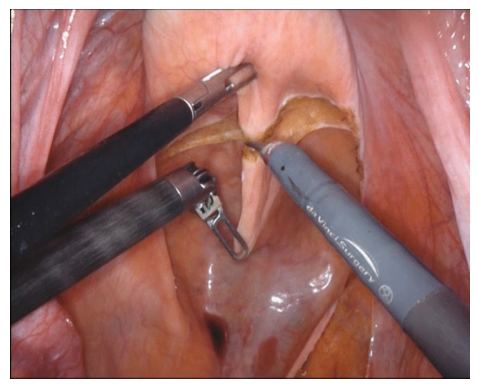

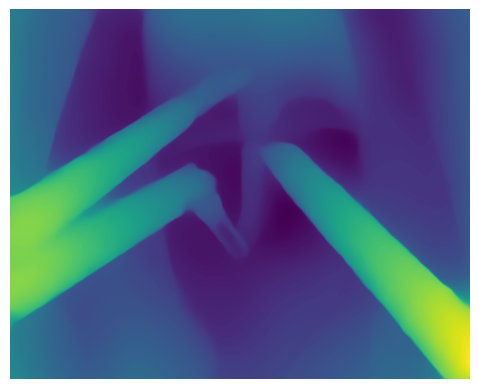

In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()

# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_tensor = invTrans(inputs['pixel_values'])
plt.figure(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);

#Customized DAM

raw input (706, 884)
head predicted_depth: torch.Size([1, 32, 518, 644])
raw input (706, 884) inputs torch.Size([1, 3, 518, 644]) predicted_depth torch.Size([1, 518, 644])
Original model train on the scale of 0 to 30
prediction: min scale = 4.5129957 max scale= 18.941662


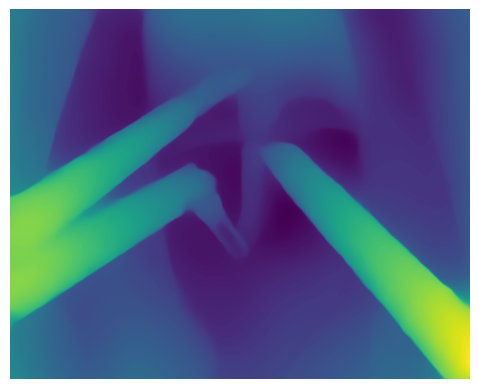

In [7]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

class DepthAnythingDepthEstimationHead(nn.Module):

    def __init__(self, model_head):
        super().__init__()

        # self.head_in_index = config.head_in_index
        # self.patch_size = config.patch_size

        # features = config.fusion_hidden_size
        self.conv1 = model_head.conv1
        self.conv2 = model_head.conv2
        self.activation1 = nn.ReLU()
        self.conv3 = model_head.conv3
        self.activation2 = nn.ReLU()

    def forward(self, hidden_states, height, width):
        #hidden_states = hidden_states[self.head_in_index]#[1, 64, 144, 176]
        #print('Final Head:',hidden_states.shape)
        predicted_depth = self.conv1(hidden_states)
        predicted_depth = nn.functional.interpolate(
            predicted_depth,
            (int(height), int(width)),
            mode="bilinear",
            align_corners=True,
        )
        print('head predicted_depth:', predicted_depth.shape)
        predicted_depth = self.conv2(predicted_depth)
        predicted_depth = self.activation1(predicted_depth)
        predicted_depth = self.conv3(predicted_depth)
        predicted_depth = self.activation2(predicted_depth)
        predicted_depth = predicted_depth.squeeze(dim=1)  # shape (batch_size, height, width)

        return predicted_depth


class Customised_DAM(nn.Module):
    def __init__(self,):
        super(Customised_DAM, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
        self.config = model.config
        self.backbone = model.backbone
        self.neck = model.neck
        model_head = model.head
        self.head = DepthAnythingDepthEstimationHead(model_head)
        model.post_init()


    def forward(self, pixel_values):
        outputs = self.backbone.forward_with_filtered_kwargs(
            pixel_values, output_hidden_states=None, output_attentions=None
        ) # pixel_values:[3, 256, 320] , output:4, [1, 397, 384]
        hidden_states = outputs.feature_maps
        _, _, height, width = pixel_values.shape
        patch_size = self.config.patch_size
        patch_height = height // patch_size
        patch_width = width // patch_size
        # print('h,w, p, ph, pw', height, width, patch_size, patch_height, patch_width) #h,w, p, ph, pw 256 320 14 18 22
        # print('hidden_states1', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        hidden_states = self.neck(hidden_states, patch_height, patch_width)
        #[1, 64, 18, 22], [1, 64, 36, 44], [1, 64, 72, 88], [1, 64, 144, 176]
        # print('hidden_states2', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        predicted_depth = self.head(hidden_states[3], height, width)
        # outputs = {}
        # outputs[("disp", 0)] = self.head(hidden_states[3], height, width)
        # outputs[("disp", 1)] = self.head(hidden_states[3], height/2, width/2)
        # outputs[("disp", 2)] = self.head(hidden_states[3], height/4, width/4)
        # outputs[("disp", 3)] = self.head(hidden_states[3], height/8, width/8)
        # print(outputs[("disp", 0)].shape, outputs[("disp", 1)].shape,outputs[("disp", 2)].shape,outputs[("disp", 3)].shape,)
        # return outputs[("disp", 0)]
        return predicted_depth

url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
print('raw input', image.size[::-1])
inputs = image_processor(images=image, return_tensors="pt")

# image_shape=(256,320)
# inputs['pixel_values'] = torch.nn.functional.interpolate(inputs['pixel_values'], size=image_shape, mode="bilinear", align_corners=True)

model_dare = Customised_DAM()
with torch.no_grad():
    predicted_depth = model_dare(**inputs)

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)

# visualize the prediction
output = predicted_depth.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);